#### 1) Train classifier on time bin A (tbA) vs baseline tb, then test how wll can decode a 2nd tb (not doing this anymore. Will do pearsons instead)
## 2) decode tb (to see how distinct/variable representations are across tbs)

In [1]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [5]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding win_sess_across_tb_vhpc'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [8]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
all_animals =     'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
pre_animals =     'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
post_animals =    'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
pre_rev_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
post_rev_animals ='c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
catch_animals =   'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'

In [9]:
sessions = 'pre','post','pre_rev','post_rev','catch'

In [10]:
for sess in sessions:
    for dur in 5,: #use 5 for 0.5sec, 1 for 1 sec and 2 for 2sec
        exec("patterns_tb_%s_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb_%s_%s',\
                                                           '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,dur,sess,sess,dur,sess))
        exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                         '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,sess))

In [11]:
#delta_t0 = 0.5sec
#from referenced notebook, 28 time bins total beginning at 3s prior to odor onset and running through 10.5s post onset

#t_start0 = -3  # sec
#t_stop0 = 11  # sec

In [12]:
#comparisons = 'preVSpost','preVSpre_rev','preVSpost_rev','postVSpre_rev','postVSpost_rev','pre_revVSpost_rev','postVScatch','post_revVScatch'

##### decoding time bins

In [9]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_within(patterns, labels, n_cells=None):
#     which_train = range(90)
#     which_test = range(90)
#    cv =LeaveOneOut()
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [14]:
for sess in sessions:
    for t in range(len(patterns_tb_pre_5['90'])): #how many time bins
        exec("%s_tb_%s = {}"%(sess,t))
        for ani in eval('%s_animals'%sess):
            try:
                #print comp.split('-')[0],
                #print ani,
                #print t,
                exec("%s_tb_%s['%s'] = patterns_tb_%s_5['%s'][%s]"%(sess,t,ani,sess,ani,t))
            except IOError as error:
                print 'ERROR'
            continue

In [15]:
%time
#individual trial-types only
relabel_rw_tb1 = {0:-1, 1:0, 2:-1}
relabel_rw_tb2 =  {0:-1, 1:1, 2:-1}
relabel_sh_tb1 = {0:-1, 1:-1, 2:0}
relabel_sh_tb2 =  {0:-1, 1:-1, 2:1}
relabel_csm_tb1 = {0:0, 1:-1, 2:-1}
relabel_csm_tb2 =  {0:1, 1:-1, 2:-1}
relabel_all_tb1 = {0:0, 1:0, 2:0}
relabel_all_tb2 =  {0:1, 1:1, 2:1}

n_loops = 10

for vs in 'all','rw','sh','csm':
    #for dur in 5,: #1,3
    for sess in sessions:
        exec("labels_%s_%s = {}"%(vs,sess))
        for ani in eval("%s_animals"%sess):
            exec("labels_%s_%s[ani] = np.r_[[relabel_%s_tb1[l] for l in labels_%s[ani]]+[relabel_%s_tb2[l] for l in labels_%s[ani]]]"%(vs,sess,vs,sess,vs,sess))
        for t in range(25):
            for c in range(25):
                exec("patterns1 = %s_tb_%s"%(sess,t))
                exec("patterns2 = %s_tb_%s"%(sess,c))
                patterns = {}
                for ani in eval("%s_animals"%sess):
                    patterns[ani] =np.concatenate((patterns1[ani],patterns2[ani]),axis=0)
                exec("%s_%s_scores_tb%svs%s = np.r_[[do_test_within(patterns,labels_%s_%s,n_cells=None)\
                        for r in range(n_loops)]]"%(vs,sess,t,c,vs,sess))
        exec("print '%s %s', 'DONE','    ',"%(vs,sess))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs
all pre DONE      all post DONE      all pre_rev DONE      all post_rev DONE      all catch DONE      rw pre DONE      rw post DONE      rw pre_rev DONE      rw post_rev DONE      rw catch DONE      sh pre DONE      sh post DONE      sh pre_rev DONE      sh post_rev DONE      sh catch DONE      csm pre DONE      csm post DONE      csm pre_rev DONE      csm post_rev DONE      csm catch DONE     


# set whether you want to use all cells, downsample to min cells for each compared session, or dowsample to global minimum of cells across all comparisons

In [16]:
##set downsampling parameter to:
##max_cells = all cells
##intraregion_min = downsample to the comparison with fewest cells within the same hippo region
##interregion_min = downsample to the comparison with fewest cells, considering both hippo regions
##gmin = the global minimum (pretty much corresponds to interregion_min)
#
#downsample = 200
#
#if downsample == 'max_cells':
#    n_cells = None #will use all registered cells
#if downsample == 'intraregion_min':
#    n_cells = ut.load_variable('n_cells_across_min_vhpc', '../notebooks/autorestore/n_cells/')
#if downsample == 'interregion_min':
#    n_cells = ut.load_variable('n_cells_across_min_overall', '../notebooks/autorestore/n_cells/')
#if downsample == 'gmin':
#    n_cells = ut.load_variable('n_cells_gmin', '../notebooks/autorestore/n_cells/')
#if downsample == 200:
#    n_cells = 200
#
#print n_cells

### organize data for plotting. First collect all data into array, then make diff arrays with just the means (for implots)
it's a mess, I know. But it's functional!

In [17]:
for t in range(25):
    exec('csm_%s = {}'%t)
    exec('sh_%s = {}'%t)
    exec('rw_%s = {}'%t)
    exec('all_%s = {}'%t)

for vs in 'all','csm','sh','rw':
    for sess in sessions:
        for t in range(25):
            exec("%s_%s['%s'] =[]"%(vs,t,sess)) #comparisons across all time bins
            for c in range(25):
                #print t, eval("distinct%s['%s_%s_%s']"%(t,AC[i].split('__')[0],AC[i].split('__')[-1],AC[i+1].split('__')[-1]))
                eval("%s_%s['%s']"%(vs,t,sess)).insert(c,(eval('%s_%s_scores_tb%svs%s'%(vs,sess,t,c))))

In [18]:
for vs in 'all','csm','sh','rw':
    exec("all_sess_%s={}"%vs)
    for i in eval("%s_0"%(vs)):
        exec("all_sess_%s[i]=[]"%vs)
        for r in range(len(eval("%s_0[i]"%(vs)))):
            eval("all_sess_%s[i]"%vs).append(eval("%s_%s"%(vs,r))[i])
        np.array([eval("all_sess_%s[i]"%vs)])

In [19]:
for t in range(25):
    exec('csm_%s_mean = {}'%t)
    exec('sh_%s_mean = {}'%t)
    exec('rw_%s_mean = {}'%t)
    exec('all_%s_mean = {}'%t)

for vs in 'all','csm','sh','rw':
    for sess in sessions:
        for t in range(25):
            exec("%s_%s_mean['%s'] =[]"%(vs,t,sess)) #comparisons across all time bins
            for c in range(25):
                #print t, eval("distinct%s['%s_%s_%s']"%(t,AC[i].split('__')[0],AC[i].split('__')[-1],AC[i+1].split('__')[-1]))
                eval("%s_%s_mean['%s']"%(vs,t,sess)).insert(c,(eval('%s_%s_scores_tb%svs%s'%(vs,sess,t,c)).mean(1)).mean())

In [21]:
for vs in 'all','csm','sh','rw':
    exec("all_sess_%s_mean={}"%vs)
    for i in eval("%s_0_mean"%(vs)):
        exec("all_sess_%s_mean[i]=[]"%vs)
        for r in range(len(eval("%s_0_mean[i]"%(vs)))):
            eval("all_sess_%s_mean[i]"%vs).append(eval("%s_%s_mean"%(vs,r))[i])
        np.array([eval("all_sess_%s_mean[i]"%vs)])

In [22]:
for x in zip (range(len(all_sess_rw.keys())),all_sess_rw.keys()):
    print x

(0, 'pre')
(1, 'post_rev')
(2, 'post')
(3, 'catch')
(4, 'pre_rev')


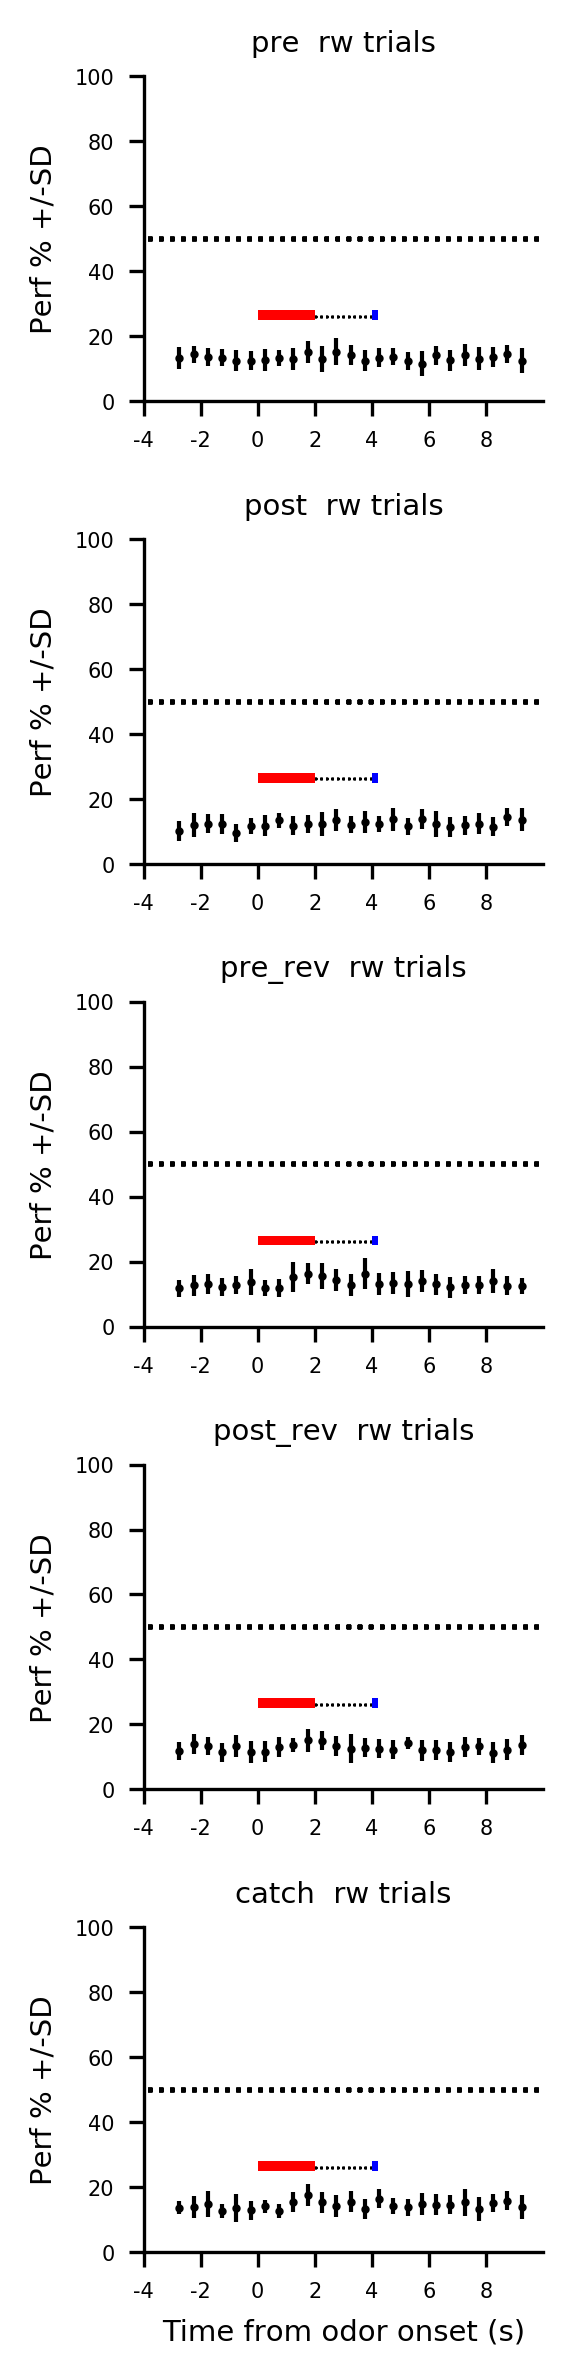

In [23]:
#to_plot = 'all'
#to_plot = 'rwVScsm'
#to_plot = 'shVScsm'
to_plot = 'rw'

order=[]
for x in [0,2,4,1,3]:
    order.append(eval("all_sess_%s.keys()[x]"%to_plot))

fig, ax = pl.subplots(len(order),1, figsize=(2, 8))    

for i,t in zip(range(len(order)), order):
    for r in range(25):
        ax[i].plot((r/2.0)-2.75, np.mean(eval("all_sess_%s"%to_plot)[t][r][r])*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(eval("all_sess_%s"%to_plot)[t][r][r])*100
        s = np.std(eval("all_sess_%s"%to_plot)[t][r][r])*100
        ax[i].errorbar((r/2.0)-2.75, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[i].set_ylim(0, 100)
        ax[i].set_xlim(-4, 10)
        ax[i].set_xticks(np.arange(-4,10, 2))
        ax[i].set_xticklabels(np.arange(-4,10, 2))
        ax[i].hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
        ax[i].set_ylabel('Perf % +/-SD')
        pt.plot_period_bar(ax[i], 25, start_end=(0, 2), color='r', delta_y=3)
        # pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
        pt.plot_period_bar(ax[i], 25, start_end=(4, 4.2), color='b', delta_y=3)
        ax[i].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
        ax[i].set_title(t+'  %s trials'%(to_plot))
ax[i].set_xlabel('Time from odor onset (s)')


fig.tight_layout(pad=2)

#fig.savefig('../img/%s_tb_matched_all_%s.jpg'%(NOTEBOOK_NAME,to_plot))

In [19]:
#build array for matrix
for sess in sessions:
    for trial in 'rw','sh','csm':
        exec("matrix_%s_%s = []"%(sess,trial))
        for t in range (25):
            exec("matrix_%s_%s.append(%s_%s_mean[sess])"%(sess,trial,trial,t))

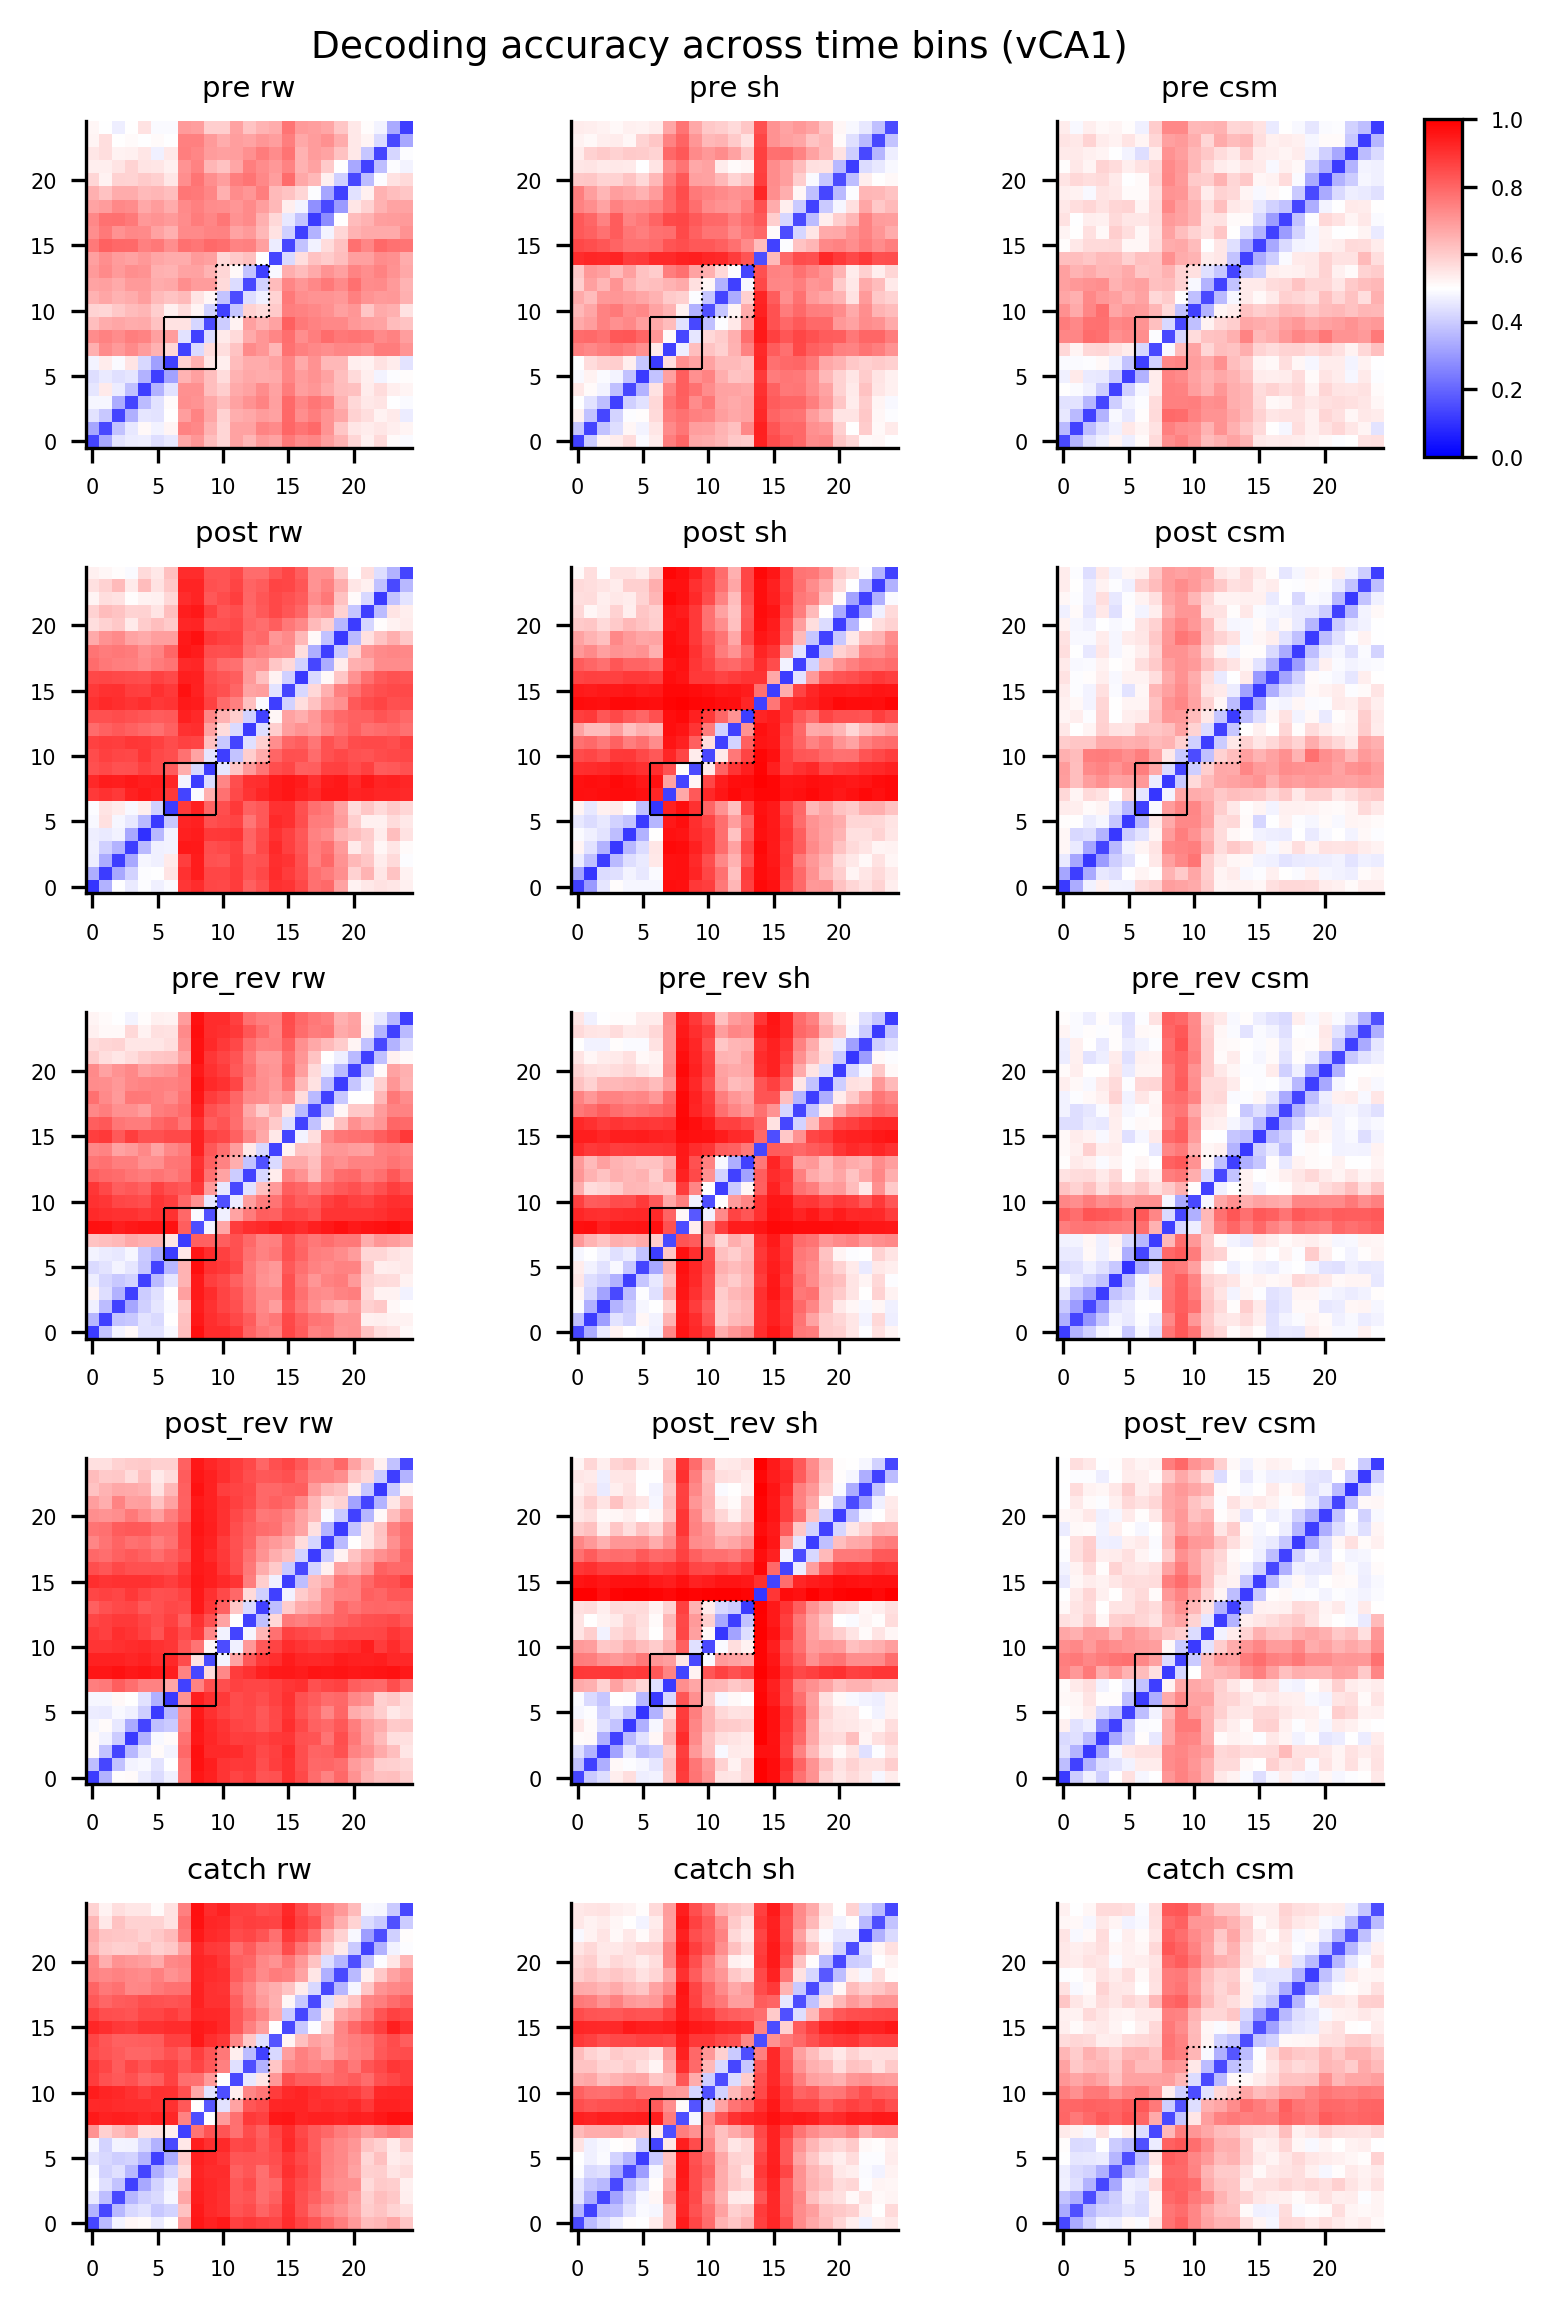

In [23]:
#importing seaborn below messes with this plot
from matplotlib import cm

fig,axs = pl.subplots(5,3,figsize=(5,7.5))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['rw','sh','csm'],[0,1,2]):
        im=axs[r][c].imshow(eval("matrix_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=1,cmap='bwr')
        axs[r][c].set_title(sess+" "+trial,fontsize=7)
        axs[r][c].vlines(5.5,5.5,9.5,color='k')
        axs[r][c].hlines(5.5,5.5,9.5,color='k')
        axs[r][c].vlines(9.5,5.5,9.5,color='k')
        axs[r][c].hlines(9.5,5.5,9.5,color='k')
        axs[r][c].vlines(9.5,9.5,13.5,color='k',linestyle=':')
        axs[r][c].hlines(9.5,9.5,13.5,color='k',linestyle=':')
        axs[r][c].vlines(13.5,9.5,13.5,color='k',linestyle=':')
        axs[r][c].hlines(13.5,9.5,13.5,color='k',linestyle=':')
        #pt.remove_axes(axs[r][c])
pl.suptitle('Decoding accuracy across time bins (vCA1)',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.82, 0.025, 0.15])
pl.colorbar(im,cax=cax)

fig.tight_layout()
fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

mega_catch_list_col1 = ['zeroes'],['preVSpost'],['preVSpre_rev'],['preVSpost_rev'],['zeroes']
mega_catch_list_col2 = ['preVSpost'],['zeroes'],['postVSpre_rev'],['postVSpost_rev'],['postVScatch']
mega_catch_list_col3 = ['preVSpre_rev'],['postVSpre_rev'],['zeroes'],['pre_revVSpost_rev'],['zeroes']
mega_catch_list_col4 = ['preVSpost_rev'],['postVSpost_rev'],['pre_revVSpost_rev'],['zeroes'],['post_revVScatch']
mega_catch_list_col5 = ['zeroes'],['postVScatch'],['zeroes'],['post_revVScatch'],['zeroes']

for vs in 'csm','sh','rw':
    for col in range(1,6): # how many entries are there in each list?
        exec("mega_catch_col%s_%s = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]"%(col,vs))
        for x in range(len(all_rw_mean['preVSpost'])):
            exec("mega_catch_col%s_%s[x] = []"%(col,vs))
            for c in range(5): #how many lists are there
                for comp in eval("mega_catch_list_col%s[%s]"%((c+1),col-1)):
                    for y in range(len(all_rw_mean['preVSpost'])):
                        #print col,x,c,comp,y,'ok',
                        if comp == 'zeroes':
                            eval("mega_catch_col%s_%s[x]"%(col,vs)).insert((25*c)+y, -1)
                        else:
                            eval("mega_catch_col%s_%s[x]"%(col,vs)).insert((25*c)+y, eval("%s_all_%s_mean[comp][y]"%(vs,x)))

for vs in 'csm','sh','rw':
    exec("mega_catch_distinct_means_%s = mega_catch_col1_%s +mega_catch_col2_%s +mega_catch_col3_%s +mega_catch_col4_%s +\
    mega_catch_col5_%s"%(vs,vs,vs,vs,vs,vs))

##to_plot = 'all'
to_plot = 'csm'
#to_plot = 'sh'
#to_plot = 'rw'
fig,ax = pl.subplots(1,figsize=(8,8))
im = ax.imshow(eval("mega_catch_distinct_means_%s"%to_plot),origin='lower', interpolation='nearest',vmin=0, vmax=1,cmap='bwr')
ticks = [12,37,62,87,112]
ax.set_xticks(ticks)
#ax.set_xticks((6,22,38,54,70),minor=True)
ax.set_yticks(ticks)
#ax.set_yticks((6,22,38,54,70),minor=True)
#ax.set_ylim(0,85)
#ax.set_xlim(0,85)
ax.set_xticklabels(['pre','post','reversal\npre','reversal\npost','catch'],fontsize=9)
ax.set_yticklabels(['pre','post','reversal\npre','reversal\npost','catch'],fontsize=9)
ax.set_ylabel('Train', fontsize=12)
ax.set_xlabel('Test', fontsize=12)
pl.hlines([24.5,49.5,74.5,99.5],-0.5,124.5,color='k')
pl.vlines([24.5,49.5,74.5,99.5],-0.5,124.5,color='k')
##pl.vlines(2,-0.5,2,color='pink')
##pl.hlines(2,-0.5,2,color='pink')
pl.title("dCA1 instability across sessions\n 0.5s bin decoding accuracy, "+to_plot)
#pl.text(2,2,"CS",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')
#pl.text(3,3,"Tr",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')
#pl.text(4,4,"US",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')

import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*25+5.5, 0*25+5.5),4,4,linewidth=.45,edgecolor='k',facecolor='none')
    CS2 = patches.Rectangle((i*25+5.5, 1*25+5.5),4,4,linewidth=.45,edgecolor='k',facecolor='none')
    CS3 = patches.Rectangle((i*25+5.5, 2*25+5.5),4,4,linewidth=.45,edgecolor='k',facecolor='none')
    CS4 = patches.Rectangle((i*25+5.5, 3*25+5.5),4,4,linewidth=.45,edgecolor='k',facecolor='none')
    CS5 = patches.Rectangle((i*25+5.5, 4*25+5.5),4,4,linewidth=.45,edgecolor='k',facecolor='none')
    Tr1 = patches.Rectangle((i*25+9.5, 0*25+9.5),4,4,linewidth=.7,edgecolor='k',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*25+9.5, 1*25+9.5),4,4,linewidth=.7,edgecolor='k',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*25+9.5, 2*25+9.5),4,4,linewidth=.7,edgecolor='k',facecolor='none',linestyle=':')
    Tr4 = patches.Rectangle((i*25+9.5, 3*25+9.5),4,4,linewidth=.7,edgecolor='k',facecolor='none',linestyle=':')
    Tr5 = patches.Rectangle((i*25+9.5, 4*25+9.5),4,4,linewidth=.7,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax.add_patch(CS1)
    ax.add_patch(CS2)
    ax.add_patch(CS3)
    ax.add_patch(CS4)
    ax.add_patch(CS5)
    ax.add_patch(Tr1)
    ax.add_patch(Tr2)
    ax.add_patch(Tr3)
    ax.add_patch(Tr4)
    ax.add_patch(Tr5)

pl.text(6.2,81.7,"CS",fontsize=7, color='k')
pl.text(10.4,85.7,"Tr",fontsize=7, color='k')
pl.text(13.4,89,"US",fontsize=7, color='k')

#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im, shrink=0.4, pad=0.03)

fig.savefig('../img/%s_MEGA_MATRIX_with_catch_%s.jpg'%(NOTEBOOK_NAME,to_plot))

In [25]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
